Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# Object Detection on IPU using YOLO v4 - Inference
This notebook demonstrates an object detection task with a YOLO v4 model using an inference pipeline run on Graphcore IPUs. Originally the code of the YOLO v4 model adapted for IPU was published in the [examples GitHub repository](https://github.com/graphcore/examples/tree/master/vision/yolo_v4/pytorch).

### Summary table

|  Domain | Tasks | Model | Datasets | Workflow |   Number of IPUs   | Execution time |
|---------|-------|-------|----------|----------|--------------|--------------|
| Vision  | Object detection | YOLO v4 | COCO | Inference | Recommended: POD4 | 2 minutes    |


![object detection on IPU](notebook/first_example.png "Last supper object detection")


## Environment setup

The best way to run this demo is on Paperspace Gradient’s cloud IPUs because everything is already set up for you. To improve your experience we preload datasets and pre-install packages. This can take a few minutes. If you experience errors immediately after starting a session please try restarting the kernel before contacting support. If a problem persists or you want to give us feedback on the content of this notebook, please reach out to through our community of developers using our [slack channel](https://www.graphcore.ai/join-community) or raise a [GitHub issue](https://github.com/graphcore/Gradient-PyTorch/issues).


To run the demo using other IPU hardware, you need to have the Poplar SDK enabled. Refer to the [Getting Started guide](https://docs.graphcore.ai/en/latest/getting-started.html#getting-started) for your system for details on how to enable the Poplar SDK. Also refer to the [Jupyter Quick Start guide](https://docs.graphcore.ai/projects/jupyter-notebook-quick-start/en/latest/index.html) for how to set up Jupyter to be able to run this notebook on a remote IPU machine.


## Requirements
Before using the model on IPU you have to build the custom operations for IPU:

In [1]:
!make

mkdir -p utils/custom_ops/build
g++ utils/custom_ops/copy_tensor/copy_custom_op.cpp -lpopart -lpoplar -lpopops -std=c++14 -g -fPIC -shared -I.. -DONNX_NAMESPACE=onnx -o utils/custom_ops/build/copy_tensor_custom_op.so
utils/custom_ops/copy_tensor/copy_custom_op.cpp:2:10: fatal error: popart/names.hpp: No such file or directory
    2 | #include <popart/names.hpp>
      |          ^~~~~~~~~~~~~~~~~~
compilation terminated.
make: *** [Makefile:22: copy_custom_op] Error 1


and install the Python dependencies:

In [2]:
# (Already installed in the conda environment)
# %pip install -r requirements.txt

## COCO dataset

This demo of inference with YOLO v4 on IPU uses the checkpoint from a model trained with the [COCO dataset](https://cocodataset.org/). With this we can demonstrate the detection of 80 different classes.

In [3]:
from ruamel import yaml

class_names = yaml.safe_load(open("configs/class_name.yaml"))["class_names"]
class_names

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

## Model preparation

In [4]:
import os
import time
import torch

from PIL import Image
from pathlib import Path

# import poptorch

path_to_detection = Path().parent.resolve()
os.environ["PYTORCH_APPS_DETECTION_PATH"] = str(path_to_detection)

We are using the original YOLO v4 model with a checkpoint trained with the COCO dataset, which we pass as `checkpoint`.

In [5]:
checkpoint = "checkpoint/yolov4_p5_reference_weights/yolov4-p5-sd.pt"

Next we download the checkpoint for the model:

In [6]:
%%bash

FILE=./checkpoint/yolov4_p5_reference_weights/yolov4-p5-sd.pt; \
if [ -f "$FILE" ]; then \
    echo "$FILE exists, no need to download."; \
else \
    mkdir checkpoint; \
    cd checkpoint; \
    curl https://gc-demo-resources.s3.us-west-1.amazonaws.com/yolov4_p5_reference_weights.tar.gz -o yolov4_p5_reference_weights.tar.gz && tar -zxvf yolov4_p5_reference_weights.tar.gz && rm yolov4_p5_reference_weights.tar.gz; \
    cd ..; \
fi 

./checkpoint/yolov4_p5_reference_weights/yolov4-p5-sd.pt exists, no need to download.


We are using a `YOLOv4InferencePipeline` class to set all the IPU specific options and wrap the PyTorch model in a PopTorch inference model. The pipeline reads the configuration parameters from the [config file](configs/inference-yolov4p5.yaml).

In [7]:
from api import YOLOv4InferencePipeline

pipeline = YOLOv4InferencePipeline(
    checkpoint_path="checkpoint/yolov4_p5_reference_weights/yolov4-p5-sd.pt",
)

/csghome/gg281/thesis/yolo-gpu/utils/tools.py:732: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(weight_path, map_location=torch.device("cpu"))


We are using the image of a famous painting (The Last Supper by Leonardo da Vinci) to demonstrate how to use the inference model. This image is stored in the repo:

In [8]:
image = Image.open("notebook/last_supper_restored.jpeg")

The pipeline call carries out the following steps: image preprocessing; a forward pass of the preprocessed image through the model; model output postprocessing.
When used for the first time, a one-time compilation of the model is triggered.
For a single IPU it should take about 3 minutes to compile the model.

In [9]:
%%time
processed_batch = pipeline(image)

original image dimensions:
h: 2560 w: 1280
img_size:  896
CPU times: user 11 s, sys: 4.6 s, total: 15.6 s
Wall time: 748 ms


/csghome/gg281/.conda/envs/thesis-gpu/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Subsequent calls are much faster:

In [10]:
%%time
processed_batch = pipeline(image)

original image dimensions:
h: 2560 w: 1280
img_size:  896
CPU times: user 10.6 s, sys: 1.12 s, total: 11.7 s
Wall time: 569 ms


You can now check what has been detected on the input image.
The output contains a list of detected objects for each image in the batch.
Each result contains five numbers: the first four are the coordinates in XYWH format (x, y, width, and height of bounding box), the fifth number represents the confidence of the prediction, and the sixth number represents the predicted class of the detected object.

In [11]:
processed_batch

[YoloOutput(x_top_left=969.6636352539062, y_top_left=673.4055786132812, width=259.1666259765625, height=299.6505432128906, detection_confidence=0.8617200255393982, detected_class_id=0.0, detected_class_name='person'),
 YoloOutput(x_top_left=1557.8753662109375, y_top_left=662.1986694335938, width=377.3467102050781, height=316.71063232421875, detection_confidence=0.8359763026237488, detected_class_id=0.0, detected_class_name='person'),
 YoloOutput(x_top_left=1756.3375244140625, y_top_left=633.3560791015625, width=284.4662170410156, height=372.2344055175781, detection_confidence=0.8266473412513733, detected_class_id=0.0, detected_class_name='person'),
 YoloOutput(x_top_left=186.1838836669922, y_top_left=846.7905883789062, width=375.3006591796875, height=763.13916015625, detection_confidence=0.8163094520568848, detected_class_id=0.0, detected_class_name='person'),
 YoloOutput(x_top_left=807.8593139648438, y_top_left=699.5647583007812, width=309.7492370605469, height=318.47021484375, detect

You can use the coordinates from the of the detected objects to plot bounding boxes on the original image.

<Figure size 2560x1920 with 0 Axes>

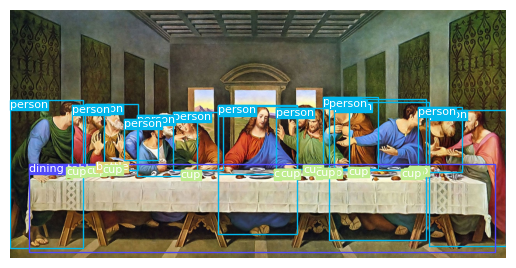

['plots/detection_20250826_193656.14.png']

In [12]:
img_paths = pipeline.plot_img(processed_batch, image)
img_paths

## Try it on your own

Let's check the YOLOv4 model on IPU with some images from the Internet.

We can use the `wget` command to store the image as `image.png`. The syntax is `!wget -O image.png [YOUR URL]`, for example:

In [13]:
# UPLOAD YOUR OWN IMAGE HERE BY REPLACING THE URL

!wget -O notebook/image.png https://www.graphcore.ai/hubfs/assets/images/content/new-team.jpg

--2025-08-26 19:36:57--  https://www.graphcore.ai/hubfs/assets/images/content/new-team.jpg
Resolving www.graphcore.ai (www.graphcore.ai)... 199.60.103.228, 199.60.103.28, 2606:2c40::c73c:67e4, ...
Connecting to www.graphcore.ai (www.graphcore.ai)|199.60.103.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215103 (210K) [image/jpeg]
Saving to: ‘notebook/image.png’

notebook/image.png  100%[===================>] 210.06K  --.-KB/s    in 0.01s   

2025-08-26 19:36:57 (17.0 MB/s) - ‘notebook/image.png’ saved [215103/215103]



Let's now use this image for inference with the same model.

original image dimensions:
h: 1714 w: 862
img_size:  896


<Figure size 2560x1920 with 0 Axes>

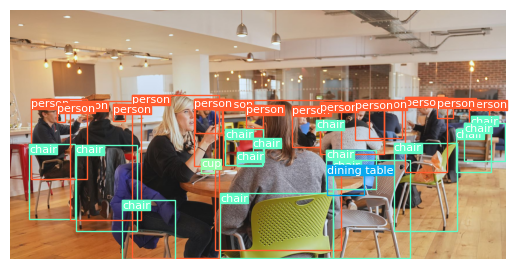

CPU times: user 11.8 s, sys: 3 s, total: 14.8 s
Wall time: 1.8 s


In [14]:
%%time
image = Image.open("notebook/image.png")

processed_batch = pipeline(image)
img_paths = pipeline.plot_img(processed_batch, image)

## Another example

In [15]:
# Download a sample image from the ZITI website
!wget -O notebook/ziti_image.png https://hawaii.ziti.uni-heidelberg.de/images/header/IMG_1619.jpeg

--2025-08-26 19:37:00--  https://hawaii.ziti.uni-heidelberg.de/images/header/IMG_1619.jpeg
Resolving hawaii.ziti.uni-heidelberg.de (hawaii.ziti.uni-heidelberg.de)... 147.142.40.253
Connecting to hawaii.ziti.uni-heidelberg.de (hawaii.ziti.uni-heidelberg.de)|147.142.40.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1585833 (1.5M) [image/jpeg]
Saving to: ‘notebook/ziti_image.png’

notebook/ziti_image 100%[===================>]   1.51M  --.-KB/s    in 0.004s  

2025-08-26 19:37:00 (426 MB/s) - ‘notebook/ziti_image.png’ saved [1585833/1585833]



original image dimensions:
h: 3791 w: 1555
img_size:  896


<Figure size 2560x1920 with 0 Axes>

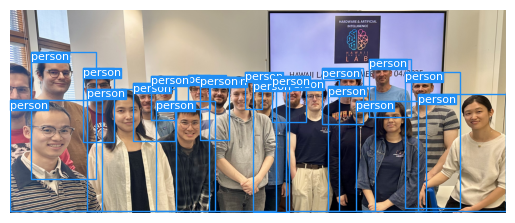

CPU times: user 14.6 s, sys: 3.42 s, total: 18 s
Wall time: 2.18 s


In [16]:
%%time
ziti_image = Image.open("notebook/ziti_image.png")

processed_batch = pipeline(ziti_image)
img_paths = pipeline.plot_img(processed_batch, ziti_image)

### Optional - Release IPUs in use

The IPython kernel has a lock on the IPUs used in running the model, preventing other users from using them. For example, if you wish to use other notebooks after working your way through this one, it may be necessary to manually run the below cell to release IPUs from use. This will happen by default if using the Run All option. More information on the topic can be found at [Managing IPU Resources](https://github.com/gradient-ai/Graphcore-HuggingFace/blob/main/useful-tips/managing_ipu_resources.ipynb).

In [17]:
# pipeline.detach()